Los datos que usará google colab. La información está en:

1. new_base_dir almacena el path de la BD reducida con la que se entrenará en este ejemplo. Dentro debe tener tres carpetas: train, test y validation y dentro de cada una, dos carpetas: Manga y Comic


In [1]:
!pip install gdown #Instala una librería para descargar archivos de Google Drive
#https://drive.google.com/file/d/1Bj80lhp2N_tzoMMHVaRBdSYToI7t0Poh/view?usp=sharing
!gdown --id 1Bj80lhp2N_tzoMMHVaRBdSYToI7t0Poh #Descarga el daataset que está en el Drive del Prof. Toro
!unzip manga_comic.zip #Descomprime el archivo del dataset
from IPython.display import Image #Librería para visualizar imágenes en Jupyter
new_base_dir=r"manga_comic"


Streaming output truncated to the last 5000 lines.
 extracting: manga_comic/train/Comic/1848.png  
 extracting: manga_comic/train/Comic/1849.png  
  inflating: manga_comic/train/Comic/185.png  
 extracting: manga_comic/train/Comic/1850.png  
 extracting: manga_comic/train/Comic/1851.png  
 extracting: manga_comic/train/Comic/1852.png  
 extracting: manga_comic/train/Comic/1853.png  
 extracting: manga_comic/train/Comic/1854.png  
 extracting: manga_comic/train/Comic/1855.png  
 extracting: manga_comic/train/Comic/1856.png  
 extracting: manga_comic/train/Comic/1857.png  
 extracting: manga_comic/train/Comic/1858.png  
 extracting: manga_comic/train/Comic/1859.png  
 extracting: manga_comic/train/Comic/186.png  
 extracting: manga_comic/train/Comic/1860.png  
  inflating: manga_comic/train/Comic/1861.png  
 extracting: manga_comic/train/Comic/1862.png  
 extracting: manga_comic/train/Comic/1863.png  
 extracting: manga_comic/train/Comic/1864.png  
 extracting: manga_comic/train/Comic/18

Visualizar una imagen

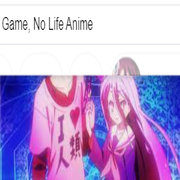

In [2]:
display(Image(filename="manga_comic/train/Manga/1005.png"))

Instanciando la red pre-entrenada VGG16 para aplicarla a la BD de perros y gatos reducida (5000 imágenes) con expansión de imágenes pero esta vez con entonación fina

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


La fase de entrenamiento podrá alterar los pesos de las 4 últimas capas de VGG16

In [4]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Crear la aumentación de datos y un modelo donde se anexa una red VGG16 con una pequeña red para clasificación.

In [20]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, kernel_regularizer='l1_l2')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid", kernel_regularizer='l1_l2')(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_2 (Flatten)         (None, 12800)             0   

Hiperparámetros para el entrenamiento y medición de desempeño

In [21]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

Convierte la información de la imagen de píxeles en un tensor numérico de punto flotante y ajusta el tamaño de la imagen porque todas tienen diferente resolución

In [15]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"test",
    image_size=(180, 180),
    batch_size=32)

Found 3942 files belonging to 2 classes.
Found 1990 files belonging to 2 classes.
Found 2649 files belonging to 2 classes.


Extrayendo las características de los conjuntos de entrenamiento, validación y prueba con sus etiquetas

In [8]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        all_features.append(images)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

print(test_features.shape)
print(test_labels.shape)

(2649, 180, 180, 3)
(2649,)


Fase de entrenamiento 

In [30]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset)

Epoch 1/10
124/124 [==============================] - 26s 208ms/step - loss: 0.6408 - accuracy: 0.9602 - val_loss: 0.9053 - val_accuracy: 0.9151
Epoch 2/10
124/124 [==============================] - 26s 208ms/step - loss: 0.6044 - accuracy: 0.9716 - val_loss: 0.8437 - val_accuracy: 0.9201
Epoch 3/10
124/124 [==============================] - 26s 206ms/step - loss: 0.5862 - accuracy: 0.9721 - val_loss: 0.9179 - val_accuracy: 0.9095
Epoch 4/10
124/124 [==============================] - 26s 207ms/step - loss: 0.5699 - accuracy: 0.9713 - val_loss: 0.8818 - val_accuracy: 0.9121
Epoch 5/10
124/124 [==============================] - 26s 205ms/step - loss: 0.5695 - accuracy: 0.9673 - val_loss: 0.9001 - val_accuracy: 0.8990
Epoch 6/10
124/124 [==============================] - 26s 207ms/step - loss: 0.5478 - accuracy: 0.9716 - val_loss: 0.8329 - val_accuracy: 0.9121
Epoch 7/10
124/124 [==============================] - 26s 206ms/step - loss: 0.5408 - accuracy: 0.9734 - val_loss: 0.8273 - val_ac

Visualización de la pérdidad y el accuracy tanto para los datos de entrenamiento como para los datos de validación y así detectar si hay overfitting

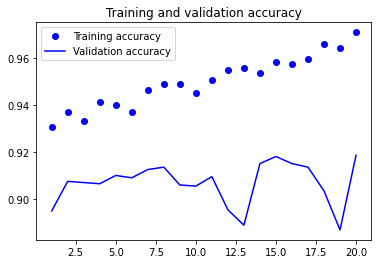

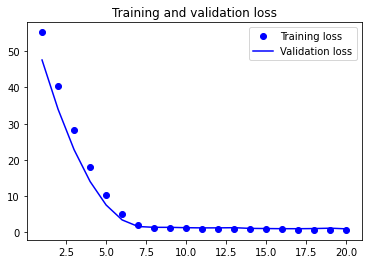

In [27]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Matriz de confusión

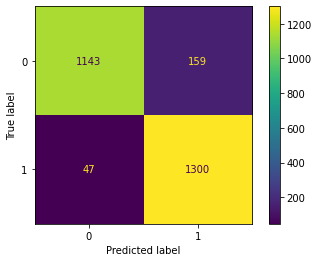

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
test_predictions = model.predict(test_features)
cm = confusion_matrix(test_labels, test_predictions > 0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Cálculo de la exactitud (en inglés, *accurracy*)

In [29]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_labels, test_predictions > 0.5))

0.922234805587014


Ejercicio:
----------
1. Desarrollar un modelo que tenga la mejor exactitud (en inglés, *accurracy*) posible en el conjunto de prueba (en inglés, *test*). Para lograrlo, hay que hacer un entrenamiento sin sobreajustar (en inglés, *overfit*)